In [1]:
%load_ext autoreload
%autoreload 2

In [17]:
import torch
from pathlib import Path
import lightning as pl
from torchvision.utils import make_grid, save_image
import matplotlib.pyplot as plt

In [18]:

class plFFFConvVAE(pl.LightningModule):
    def __init__(
        self,
        encoder,
        decoder,
        latent,
        lr=3e-4,
        lr_min: float = 1e-8,
        lr_scheduler=None,
        hutchinson_samples=2,
        beta=1.0,
    ):
        super().__init__()
        # ensure that the model is saved and can be loaded later as a checkpoint
        self.save_hyperparameters()

        self.encoder = encoder
        self.decoder = decoder
        self.latent = latent

        self.lr = lr
        self.lr_min = lr_min
        self.lr_scheduler = lr_scheduler
        self.hutchinson_samples = hutchinson_samples
        self.beta = torch.Tensor([beta])

    def forward(self, x, target=None):
        """Foward pass."""
        return self.encoder(x)

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.lr)
        if self.lr_scheduler == "cosine":
            # cosine learning rate annealing
            scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
                optimizer,
                T_max=self.trainer.max_epochs,
                eta_min=self.lr_min,
                verbose=True,
            )
        elif self.lr_scheduler == "step":
            # An scheduler is optional, but can help in flows to get the last bpd improvement
            scheduler = optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.99)
        else:
            scheduler = None
        return [optimizer], [scheduler]

    def training_step(self, batch, batch_idx):
        x, _ = batch
        B = x.size(0)
        # get the surrogate loss, latent representation, and reconstructed tensor
        surrogate_loss, v_hat, x_hat = volume_change_surrogate(
            x,
            self.encoder,
            self.decoder,
            hutchinson_samples=self.hutchinson_samples,
        )
        # compute reconstruction loss
        loss_reconstruction = torch.nn.functional.mse_loss(x_hat, x)

        # get negative log likelihoood
        v_hat = v_hat.view(B, -1)
        loss_nll = -self.latent.log_prob(v_hat).mean() - surrogate_loss

        loss = self.beta * loss_reconstruction + loss_nll

        self.log("train_loss", loss)
        return loss

    @torch.no_grad()
    def sample(self, num_samples=1, **params):
        """
        Sample a batch of images from the flow.
        """
        # sample latent space and reshape to (batches, 1, embed_dim)
        v = self.latent.sample(num_samples, **params)
        v = v.reshape(num_samples, 1, -1)
        return self.decoder(v)

    def validation_step(self, batch, batch_idx):
        x, _ = batch
        B = x.size(0)
        self.beta = self.beta.to(x.device)

        # get the surrogate loss, latent representation, and reconstructed tensor
        surrogate_loss, v_hat, x_hat = volume_change_surrogate(
            x,
            self.encoder,
            self.decoder,
            hutchinson_samples=self.hutchinson_samples,
        )
        # compute reconstruction loss
        loss_reconstruction = torch.nn.functional.mse_loss(x_hat, x).to(x.device)

        # get negative log likelihoood
        v_hat = v_hat.view(B, -1)
        loss_nll = -self.latent.log_prob(v_hat).mean() - surrogate_loss

        loss = self.beta * loss_reconstruction + loss_nll
        # Print the loss to the console
        if batch_idx % 100 == 0:
            print(f"val_loss: {loss}")
        self.log("val_loss", loss)
        return loss

In [22]:
# reload the model from checkpoint
root = Path('/Users/adam2392/pytorch_data/ciflows/vae/results/')

model_dir = root / 'check_fif_convvae_mnist_v1'
epoch = 134
step=58050
model_fname = model_dir / f'epoch={epoch}-step={step}.ckpt'
# checkpoint = torch.load(model_fname, map_location='mps')

model = plFFFConvVAE.load_from_checkpoint(model_fname)
# print(checkpoint.keys())

In [23]:

# samples = sample_from_vae(model, n_samples=16, latent_dim=16)
samples = model.sample(16)

torch.Size([3, 122, 122])


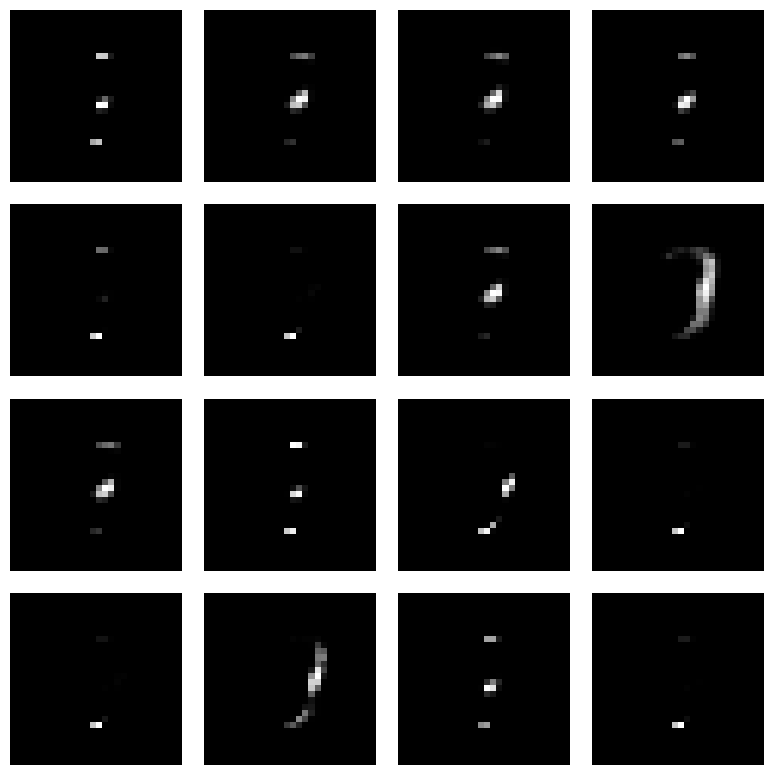

In [24]:
num_samples = 16

# Visualize generated samples
grid_size = make_grid(samples, nrow=4, padding=2)
save_image(grid_size, 'generated_samples.png', normalize=True)

print(grid_size.shape)
fig, axes = plt.subplots(4, 4, figsize=(8, 8))
for i in range(num_samples):
    ax = axes[i // 4, i % 4]
    ax.imshow(samples[i].squeeze(), cmap='gray')
    ax.axis('off')

plt.show()

In [35]:
num_samples = 2

z, log_q = model.model.q0(num_samples)
for flow in model.model.flows:
    z, log_det = flow(z)
    log_q -= log_det
    print()
    print(flow, z.flatten()[0], log_q[0])
return z, log_q


GlowBlock(
  (flows): ModuleList(
    (0): AffineCouplingBlock(
      (flows): ModuleList(
        (0): Split()
        (1): AffineCoupling(
          (param_map): ConvNet2d(
            (net): Sequential(
              (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
              (1): LeakyReLU(negative_slope=0.0)
              (2): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
              (3): LeakyReLU(negative_slope=0.0)
              (4): Conv2d(64, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            )
          )
        )
        (2): Merge()
      )
    )
    (1): Invertible1x1Conv()
    (2): ActNorm()
  )
) tensor(1.1539, grad_fn=<SelectBackward0>) tensor(-152.7195, grad_fn=<SelectBackward0>)

GlowBlock(
  (flows): ModuleList(
    (0): AffineCouplingBlock(
      (flows): ModuleList(
        (0): Split()
        (1): AffineCoupling(
          (param_map): ConvNet2d(
            (net): Sequential(
              (0): Conv2d(1, 64, kernel

SyntaxError: 'return' outside function (1581086800.py, line 9)